<a href="https://colab.research.google.com/github/garbesc/Projet-6/blob/main/Classez_des_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import des librairies
import numpy as np
import pandas as pd
import os, sys, time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.transform import resize
from IPython.display import SVG

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
folder_path = "/content/drive/MyDrive/OpenClassRooms/Projet n°6/Images/"
for fname in os.listdir(folder_path):
  subpath = os.path.join(folder_path, fname)
  for sfile in os.listdir(subpath):
    try:
      fobj = open(subpath+"/"+sfile, "rb")
      is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
    finally:
      fobj.close()

    if not is_jfif:
      # Delete corrupted image
      os.remove(subpath+"/"+sfile)
      print (sfile)


In [ ]:
image_size = (256, 256)
batch_size = 32

In [ ]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    folder_path,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size= batch_size,
    image_size= image_size,
    shuffle=True,
    seed=1337,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    validation_split=0.2,
    subset="both"
)

Found 20634 files belonging to 120 classes.
Using 16508 files for training.
Using 4126 files for validation.


In [ ]:
num_classes = len(train_ds.class_names)
num_classes

120

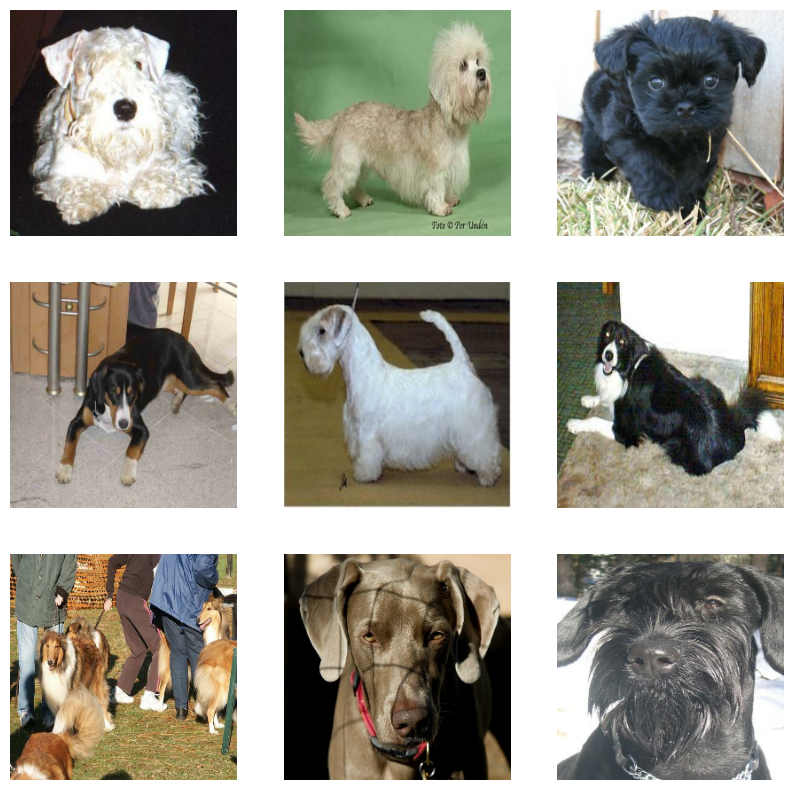

In [ ]:
# Visualisation des images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
#?        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
# Augmentation d'images
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

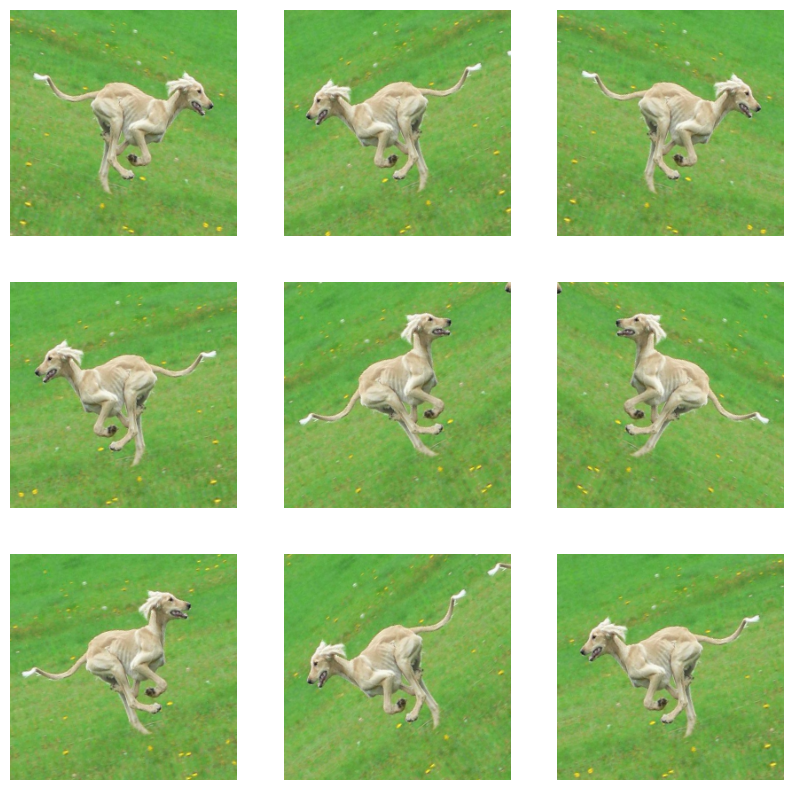

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

In [ ]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

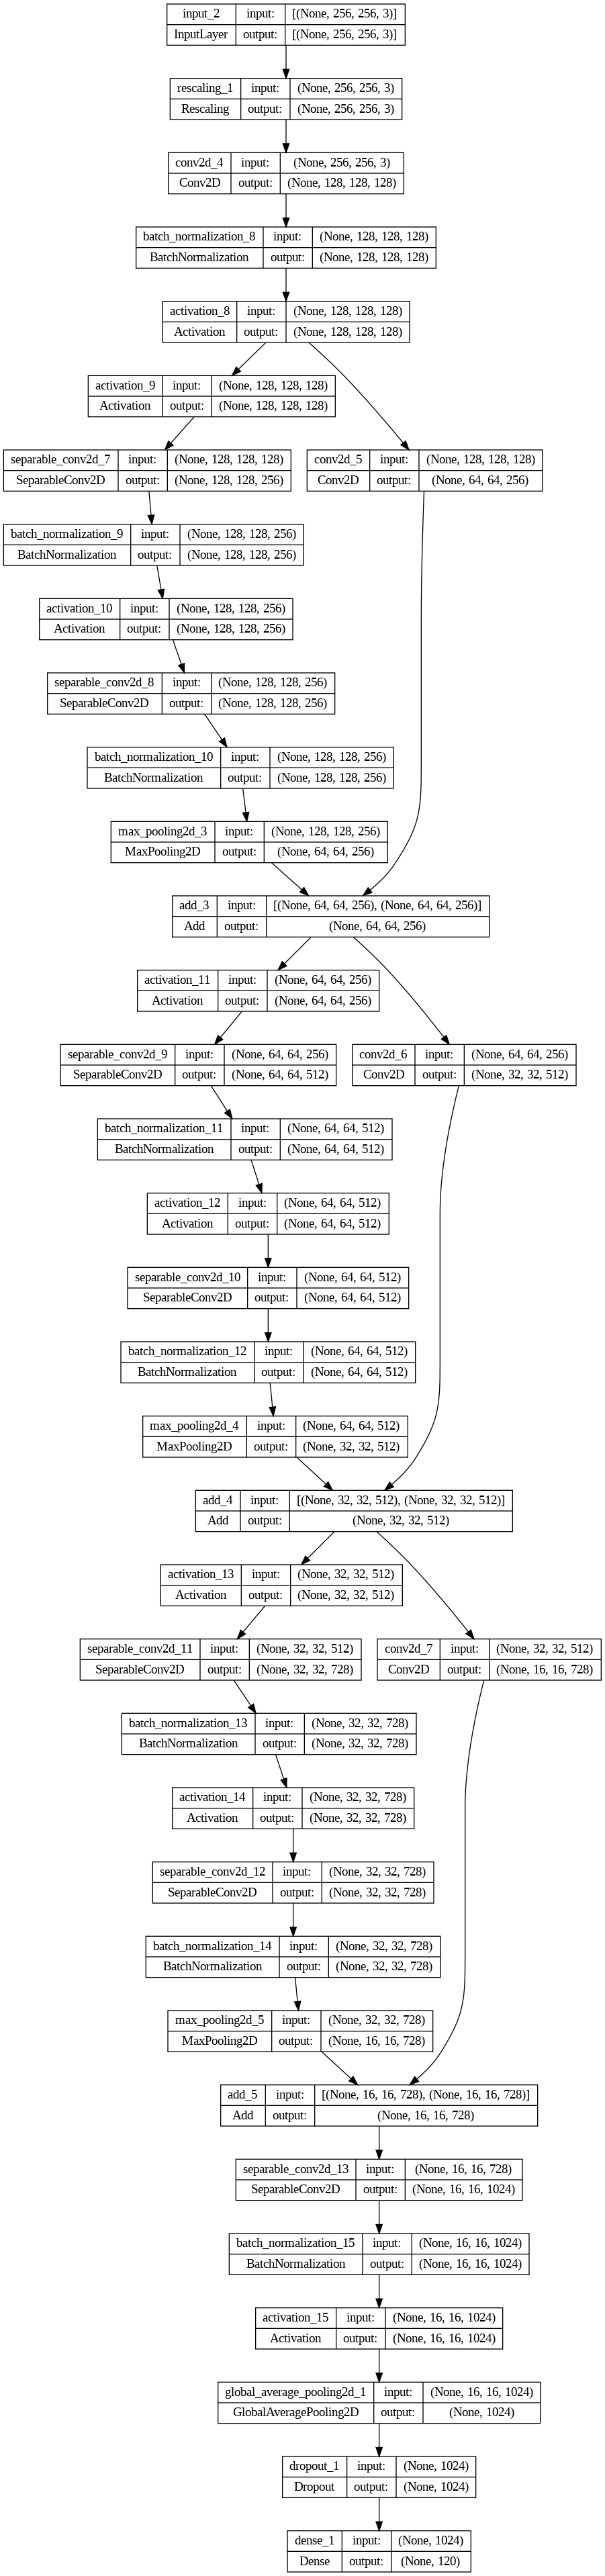

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=num_classes)
keras.utils.plot_model(model, show_shapes=True)

In [41]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25
516/516 [==============================] - 379s 675ms/step - loss: 0.0542 - accuracy: 0.0168 - val_loss: 0.0533 - val_accuracy: 0.0141
Epoch 2/25
516/516 [==============================] - 339s 654ms/step - loss: 0.0470 - accuracy: 0.0313 - val_loss: 0.0506 - val_accuracy: 0.0252
Epoch 3/25
516/516 [==============================] - 339s 655ms/step - loss: 0.0444 - accuracy: 0.0525 - val_loss: 0.0471 - val_accuracy: 0.0499
Epoch 4/25
516/516 [==============================] - 340s 656ms/step - loss: 0.0421 - accuracy: 0.0857 - val_loss: 0.0535 - val_accuracy: 0.0487
Epoch 5/25
516/516 [==============================] - 340s 657ms/step - loss: 0.0401 - accuracy: 0.1141 - val_loss: 0.0437 - val_accuracy: 0.1001
Epoch 6/25
516/516 [==============================] - 340s 656ms/step - loss: 0.0383 - accuracy: 0.1467 - val_loss: 0.0415 - val_accuracy: 0.1105
Epoch 7/25
516/516 [==============================] - 340s 656ms/step - loss: 0.0368 - accuracy: 0.1805 - val_loss: 0.0426 -

In [1]:
img = keras.utils.load_img(
    "/content/drive/MyDrive/OpenClassRooms/Projet n°6/Images/snooky.jpg", target_size=image_size
)
img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
#print(f"This image is {100 * (1 - score):.2f}%)

NameError: ignored